In [9]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split, GridSearchCV

# from pipe import *
from lesson_functions import *

# Read in cars and notcars
# In Python 3.5 and newer use the new recursive **/ functionality

cars_small = glob.glob('data/vehicles_smallset/**/*.jpeg', recursive=True)
cars_large = glob.glob('data/vehicles/**/*.png', recursive=True)

notcars_small = glob.glob('data/non-vehicles_smallset/**/*.jpeg', recursive=True)
notcars_large = glob.glob('data/non-vehicles/**/*.png', recursive=True)

print('   cars: small(%d), large(%d)' % (len(cars_small), len(cars_large)))
print('notcars: small(%d), large(%d)' % (len(notcars_small), len(notcars_large)))

cars = []
notcars = []

# TODO: only small dataset is effective.

cars.extend(cars_small)
cars.extend(cars_large)

notcars.extend(notcars_small)
notcars.extend(notcars_large)

sample_size = 2000
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

print('Total cars(%d) notcars(%d)' % (len(cars), len(notcars)))

### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb'   # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9              # HOG orientations
pix_per_cell = 8        # HOG pixels per cell
cell_per_block = 2      # HOG cells per block
hog_channel = 'ALL'     # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32          # Number of histogram bins
spatial_feat = False    # Spatial features on or off
hist_feat = True
hog_feat = True         # HOG features on or off
y_start_stop = [450, None]  # Min and max in y to search in slide_window()


car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

print(X.shape)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

# Check the training time for the SVC
t = time.time()

# Use a linear SVC 
svc = LinearSVC()
svc.fit(X_train, y_train)

# parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svr = SVC()
# clf = GridSearchCV(svr, parameters)
# clf.fit(X_train, y_train)
# svc = clf.best_estimator_


t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t = time.time()

   cars: small(1196), large(8792)
notcars: small(1125), large(8968)
Total cars(9988) notcars(10093)
(20081, 5388)
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5388
7.46 Seconds to train SVC...
Test Accuracy of SVC =  0.9928


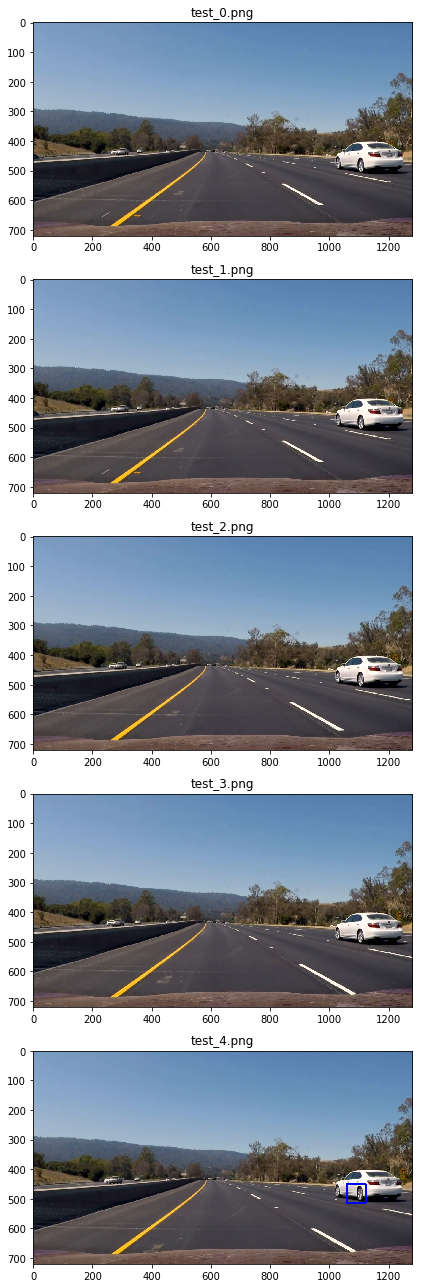

In [4]:
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
# image = image.astype(np.float32)/255

fig = plt.figure(figsize=(9, 18))

for i in range(0, 5):
    test_image = 'record/test_%d.png' % i

    image = mpimg.imread(test_image)
    image = (image[:, :, :3] * 255).astype(np.uint8)
    draw_image = np.copy(image)
    
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                       xy_window=(64, 64), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                                 spatial_size=spatial_size, hist_bins=hist_bins,
                                 orient=orient, pix_per_cell=pix_per_cell,
                                 cell_per_block=cell_per_block,
                                 hog_channel=hog_channel, spatial_feat=spatial_feat,
                                 hist_feat=hist_feat, hog_feat=hog_feat)

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

    plt.subplot(5, 1, i + 1)
    plt.title('test_%d.png' % i)
    plt.imshow(window_img)

fig.tight_layout()

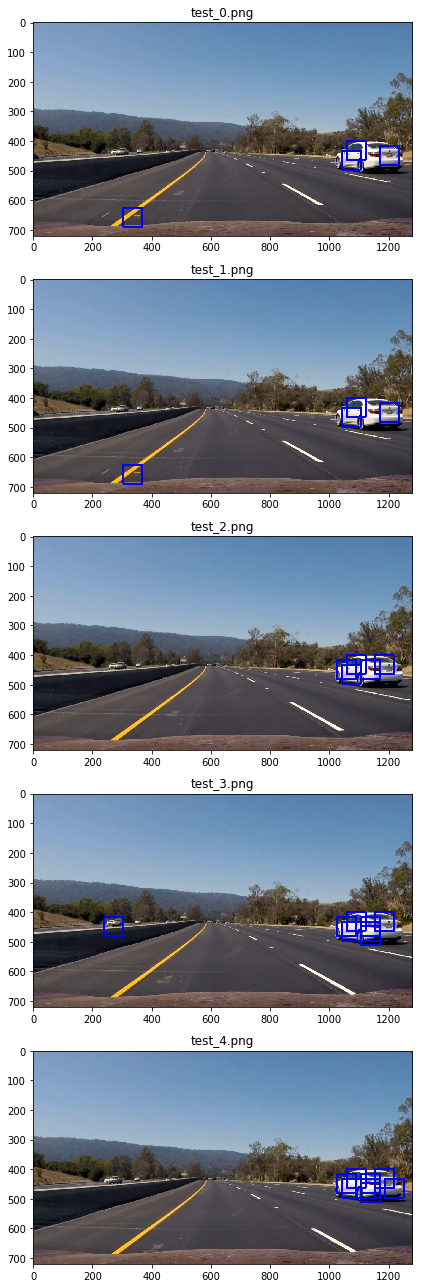

In [10]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient,
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    
    # TODO: jpeg or png?
    # img = img.astype(np.float32) / 255

    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(
                np.hstack((hist_features, hog_features)).reshape(1, -1))

            test_prediction = svc.predict(test_features)

            if test_prediction == 1:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                bboxes.append(((xbox_left, ytop_draw + ystart), 
                               (xbox_left + win_draw, ytop_draw + win_draw + ystart)))
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart),
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0, 0, 255), 6)

    return draw_img, bboxes


ystart = 400
ystop = None
scale = 1

fig = plt.figure(figsize=(9, 18))

bboxes_dict = {}

for i in range(0, 5):
    test_image = 'record/test_%d.png' % i

    img = mpimg.imread(test_image)
    img = (img[:, :, :3] * 255).astype(np.uint8)

    out_img, bboxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                                spatial_size, hist_bins)
    bboxes_dict[i] = bboxes
    plt.subplot(5, 1, i + 1)
    plt.title('test_%d.png' % i)
    plt.imshow(out_img)

fig.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


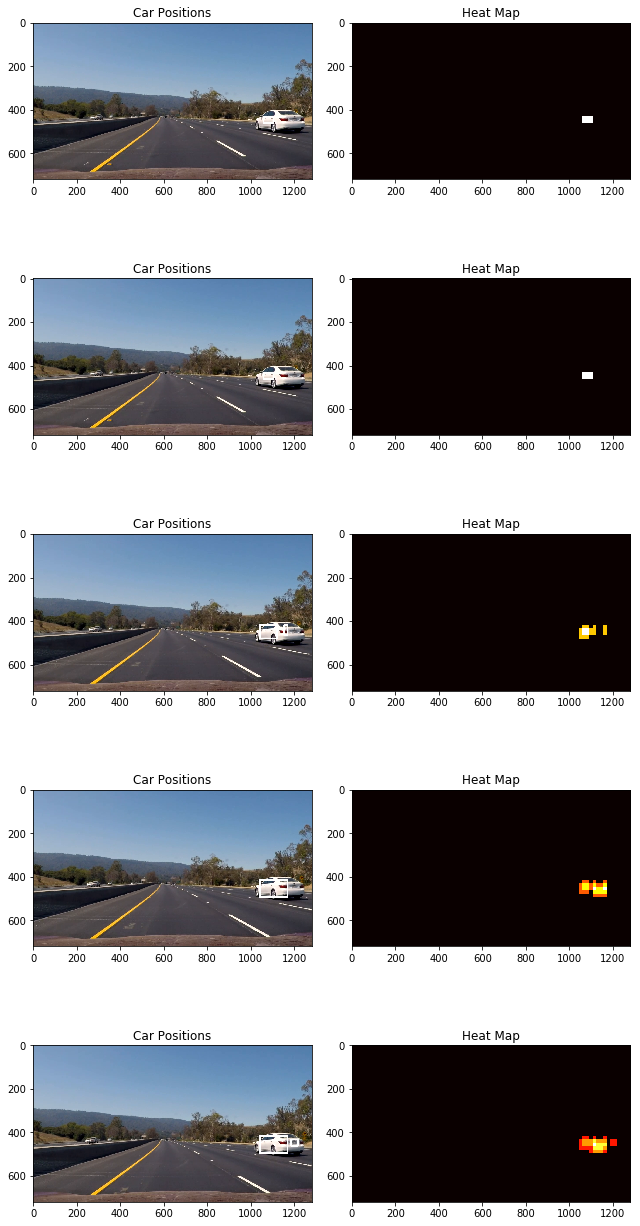

In [11]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

fig = plt.figure(figsize=(9, 18))

for i in range(0, 5):
    test_image = 'record/test_%d.png' % i

    image = mpimg.imread(test_image)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat, bboxes_dict[i])

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    plt.subplot(5, 2, 2*(i+1)-1)
    plt.imshow(draw_img)
    plt.title('Car Positions')

    plt.subplot(5, 2, 2*(i+1))
    plt.imshow(heatmap, cmap='hot')
    plt.title('Heat Map')

fig.tight_layout()

In [8]:
record_image = False
record_dir = 'record'

def process_image(image):    
    result = np.copy(image)
    if record_image is True:
        plt.imsave('%s/test_%d' % (record_dir, process_image.no), image)
        process_image.no += 1
    result, bboxes = find_cars(result, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                                spatial_size, hist_bins)
    return result

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

process_image.no = 0

white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4').subclip(11, 12)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 96%|█████████▌| 25/26 [01:30<00:03,  3.64s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 1min 30s, sys: 337 ms, total: 1min 30s
Wall time: 1min 31s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))